# Feature Selection for log_diff_model (Multivariate Model)

In [73]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
bdi = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
bdi.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [75]:
bdi["Date"] = pd.to_datetime(bdi["Date"])
bdi.set_index("Date", inplace=True)
bdi= bdi[bdi.index != "1995-01-03"]
bdi.drop(columns="Unnamed: 0", inplace=True)
bdi.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


In [76]:
feat = pd.read_csv("../raw_data/data/merged_features.csv")
feat["Date"] = pd.to_datetime(feat["Date"])
feat.set_index("Date", inplace=True)
feat.drop(columns="Unnamed: 0", inplace=True)
feat = feat[["DAP"]]
feat.rename(columns={"DAP":"DAP"}, inplace=True)
dap=feat
dap

,DAP
Date,
1995-01-03,198.630000
1995-01-04,198.630000
1995-01-05,198.630000
1995-01-06,198.630000
1995-01-09,198.630000
...,...
2022-11-08,306.576271
2022-11-09,297.296610
2022-11-10,288.016949


In [77]:
df = pd.merge(bdi, dap, on="Date", how="inner")
#df.drop(columns="Price_y", inplace=True)


In [78]:
df.head(3)

,Price,abs_price,log_price,log_diff,DAP
Date,,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664,198.63
1995-01-05,1967.0,6.0,3.293804,0.001327,198.63
1995-01-06,1983.0,16.0,3.297323,0.003518,198.63


# Data Cleaning

## Holdout Method (manual, chronological)

In [79]:
input_length = len(df)

In [80]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [81]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [82]:
X_train = df_train[["Price","DAP"]]
y_train = df_train["log_diff"]

X_test  = df_test[["Price","DAP"]]
y_test = df_test["log_diff"]

In [83]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [84]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=20, batch_size=8, sampling_rate=1, stride=1)

In [85]:
len(generator)

704

In [86]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=20, batch_size=8, sampling_rate=1, stride=1)

In [87]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(8, 20, 2) (8,)
[[0.14519214 0.06948717]
 [0.14571379 0.06948717]
 [0.14710485 0.06948717]
 [0.14806121 0.06948717]
 [0.14988698 0.06948717]
 [0.15023474 0.06948717]
 [0.15188663 0.06948717]
 [0.15379934 0.06948717]
 [0.15440793 0.06948717]
 [0.15475569 0.06948717]
 [0.15475569 0.06948717]
 [0.15466875 0.06948717]
 [0.1537124  0.06948717]
 [0.15240828 0.06948717]
 [0.15136498 0.06948717]
 [0.1501478  0.06948717]
 [0.14823509 0.06948717]
 [0.14710485 0.06948717]
 [0.1465832  0.06948717]
 [0.14623544 0.06948717]] -0.0015435717560743


# The Model

In [88]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [89]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [90]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_mae", patience=100, restore_best_weights=True)

In [92]:
#Initializing and compiling model:

def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(60, activation="tanh", input_shape=(20,2), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training and Testing

In [93]:
#Instantiating model

model = init_model()

In [94]:
#Model layers & params overview:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60)                15120     
                                                                 
 dense_8 (Dense)             (None, 100)               6100      
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,321
Trainable params: 21,321
Non-trainable params: 0
_________________________________________________________________


In [95]:
#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=1000, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/1000
704/704 [==============================] - 3s 3ms/step - loss: 1.1586e-04 - mae: 0.0076 - val_loss: 1.4540e-04 - val_mae: 0.0093
Epoch 2/1000
704/704 [==============================] - 2s 2ms/step - loss: 6.9184e-05 - mae: 0.0059 - val_loss: 1.1127e-04 - val_mae: 0.0080
Epoch 3/1000
704/704 [==============================] - 2s 2ms/step - loss: 6.0377e-05 - mae: 0.0054 - val_loss: 1.0669e-04 - val_mae: 0.0080
Epoch 4/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.9803e-05 - mae: 0.0053 - val_loss: 1.1218e-04 - val_mae: 0.0079
Epoch 5/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.8380e-05 - mae: 0.0053 - val_loss: 1.0623e-04 - val_mae: 0.0079
Epoch 6/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.9684e-05 - mae: 0.0053 - val_loss: 1.0645e-04 - val_mae: 0.0079
Epoch 7/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.8817e-05 - mae: 0.0052 - val_loss: 1.0961e-04 - val_mae: 0.0081
Epoch 

704/704 [==============================] - 2s 2ms/step - loss: 2.5458e-05 - mae: 0.0033 - val_loss: 3.6036e-05 - val_mae: 0.0036
Epoch 59/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.4978e-05 - mae: 0.0033 - val_loss: 3.3715e-05 - val_mae: 0.0038
Epoch 60/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.5260e-05 - mae: 0.0033 - val_loss: 3.3949e-05 - val_mae: 0.0035
Epoch 61/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.4539e-05 - mae: 0.0032 - val_loss: 3.6989e-05 - val_mae: 0.0039
Epoch 62/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.4531e-05 - mae: 0.0032 - val_loss: 3.6085e-05 - val_mae: 0.0040
Epoch 63/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.4243e-05 - mae: 0.0033 - val_loss: 3.2226e-05 - val_mae: 0.0036
Epoch 64/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.5016e-05 - mae: 0.0033 - val_loss: 4.1359e-05 - val_mae: 0.0044
Epoch 65/1000

704/704 [==============================] - 2s 2ms/step - loss: 2.0028e-05 - mae: 0.0028 - val_loss: 3.6722e-05 - val_mae: 0.0037
Epoch 116/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.0426e-05 - mae: 0.0029 - val_loss: 3.5439e-05 - val_mae: 0.0037
Epoch 117/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.0298e-05 - mae: 0.0029 - val_loss: 3.7454e-05 - val_mae: 0.0038
Epoch 118/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.0331e-05 - mae: 0.0029 - val_loss: 3.3715e-05 - val_mae: 0.0039
Epoch 119/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.0039e-05 - mae: 0.0029 - val_loss: 3.3761e-05 - val_mae: 0.0036
Epoch 120/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.0083e-05 - mae: 0.0029 - val_loss: 6.0022e-05 - val_mae: 0.0052
Epoch 121/1000
704/704 [==============================] - 2s 2ms/step - loss: 2.0372e-05 - mae: 0.0029 - val_loss: 3.4897e-05 - val_mae: 0.0037
Epoch 1

In [96]:
model.evaluate(generator_val)

175/175 [==============================] - 0s 619us/step - loss: 3.2313e-05 - mae: 0.0033


[3.231257142033428e-05, 0.003259592456743121]

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

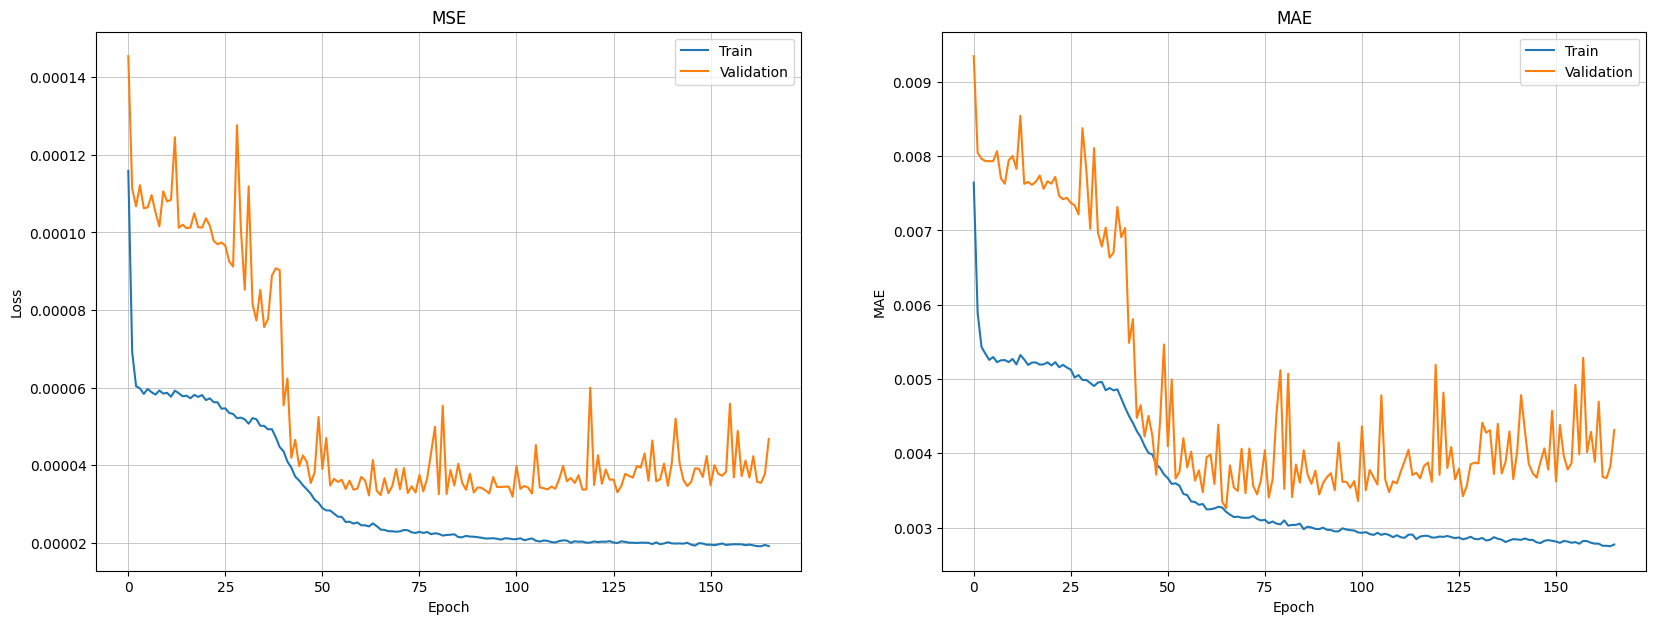

In [97]:
# Learning Curves:
plot_history(history)

In [98]:
#Baseline MAE
0.0048812746058099115

0.0048812746058099115

# Learning Curves viz code:

In [32]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax